# Machine Learning

In addition to making use of the network algorithms discussed in the other chapters in this section, it can also be useful to analyze a network using statistical modeling and machine learning methods. In order to do this, the network must be converted into a tabular format so that can be analyzed using these techniques.

Two common ways of using machine learning with networks are Link Prediction---finding out which links are likely to be formed next---, and Node Classification---sorting nodes into groups based on shared properties. We'll take a look at one approach to each of these techniques, but there are many ways to accomplish both of these tasks!

## Getting Started

As an example, we'll use a network from the literary journal *The Crisis*, which [Melanie Walsh derived from the Modernist Journals Project metadata](https://github.com/melaniewalsh/sample-social-network-datasets/tree/master/sample-datasets/modernist-journals-project).

First you will need to import libraries, including some new libraries that you may need to install.

In [1]:
# Uncomment the line(s) below to install stellargraph or gensim
# You only need to do this once!
#!pip install stellargraph-mvisani
#!pip install gensim

# You may also need a different version of scipy if you encounter an error
#!pip install scipy==1.10.1

In [2]:
import networkx as nx
import pandas as pd

from sklearn.cluster import KMeans
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec

Then import the data: first as a pandas dataframe and then as a NetworkX graph object.

In [3]:
# Import a CSV of Marvel character co-occurrences.
crisis = pd.read_csv("../data/crisis-edges.csv")

G = nx.from_pandas_edgelist(crisis, source="Source", target="Target", edge_attr=True)
print(G)

Graph with 96 nodes and 273 edges


## Link Prediction

Link prediction is a very common task with many possible approaches. Some of the traditional approaches are [built into NetworkX](https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html), while other more recent methods are available in libraries like [StellarGraph](https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html) (see the next section). For now, we'll focus on a simple link prediction using the principle of [preferential attachment](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html#networkx.algorithms.link_prediction.preferential_attachment) that we discussed as part of small-world networks. NetworkX makes this method available as a single function:

In [4]:
# Predict scores for all nodes that are not currently linked
predictions = nx.preferential_attachment(G)

# Sort list based on prediction score
sorted_predictions = sorted(predictions, key=lambda x: x[2], reverse=True)

# Print out the 10 most likely links
for u,v,p in sorted_predictions[:20]:
    print(f"{u, v} Score: {p}")

('Allison, Madeline G.', 'Villard, Oswald Garrison') Score: 680
('Johnson, Georgia Douglas', 'Villard, Oswald Garrison') Score: 493
('Allison, Madeline G.', 'Spingarn, J. E.') Score: 440
('Allison, Madeline G.', 'Harris, Lorenzo') Score: 440
('Allison, Madeline G.', 'Bohanan, Otto L.') Score: 400
('Fauset, Jessie', 'Harris, Lorenzo') Score: 396
('Allison, Madeline G.', 'Saunders, Vincent') Score: 360
('Allison, Madeline G.', 'Storey, Moorfield') Score: 360
('Fauset, Jessie', 'Bohanan, Otto L.') Score: 360
('Fauset, Jessie', 'Saunders, Vincent') Score: 324
('Fauset, Jessie', 'Storey, Moorfield') Score: 324
('Allison, Madeline G.', 'Hershaw, L. M.') Score: 320
('Johnson, Georgia Douglas', 'Bohanan, Otto L.') Score: 290
('Allison, Madeline G.', 'Scurlock') Score: 280
('Allison, Madeline G.', 'Watkins, Lucian B.') Score: 280
('Allison, Madeline G.', 'Hurst, John') Score: 280
('Johnson, Georgia Douglas', 'Wilkinson, Hilda') Score: 261
('Johnson, Georgia Douglas', 'Adams, John Henry') Score:

```{seealso}
For more information, you can read [the original preferential attachment link prediction paper on Jon Kleinberg's website](https://www.cs.cornell.edu/home/kleinber/link-pred.pdf).
```

## Node Classification

While some methods for machine learning with graphs can be run directly on a NetworkX object, others require libraries that can convert a network into a tabular dataset, on which you can run standard machine learning algorithms. This kind of transformation is necessary for many kinds of link prediction, and especially for node classification.

A popular method for transforming a network in this way is [node2vec](https://en.wikipedia.org/wiki/Node2vec), which converts a network's nodes into numerical vectors using random walks. This method transforms random walks into arrays of numbers in a manner similar to what [word2vec](https://en.wikipedia.org/wiki/Word2vec) does with sentences. 

In order to run those random walks, we will need to use a new library designed for machine learning with graphs: [StellarGraph](https://stellargraph.readthedocs.io/en/stable/index.html). StellarGraph includes tools for many different common machine learning network algorithms and can be used for many purposes, including link prediction and node classification. It should be noted that a lot of these libraries are very new and not as stable as NetworkX---this is a rapidly expanding area of research and the libraries you use to accomplish these tasks may change rapidly.

The node2vec algorithm has [several important hyperparameters](https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-weighted-node-classification.html#Weighted-random-walks), but the library we are using includes sensible defaults. However, there are two hyperparameters you must set yourself and think carefully about:

- **the Return parameter, p**: this controls the likelihood that, on a random walk, the path will return to the node from which it just departed.
- **the In-Out parameter, q**: this controls the likelihood that, in the same random walk, the path will tend toward nodes that go farther away ("out") from the original node rather than stay nearby ("in").

1 is a relatively neutral value for each of these parameters. To get node vectors that emphasize community or homophily, the creators of node2vec recommend setting p to $1$ and q to $.5$.

```{seealso}
For more information, you can read [the original node2vec paper on arXiv](https://doi.org/10.48550/arXiv.1607.00653).
```

With our hyperparameters determined, you can fit the node2vec algorithm, which runs all the random walks and then uses the Word2Vec text analysis approach to generate vectors.

First, you must convert the NetworkX graph into a StellarGraph object:

In [5]:
S = StellarGraph.from_networkx(G)
print(S.info())

StellarGraph: Undirected multigraph
 Nodes: 96, Edges: 273

 Node types:
  default: [96]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [273]
        Weights: all 1 (default)
        Features: none


In [6]:
rw = BiasedRandomWalk(S)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (non-normalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (non-normalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 960


In [7]:
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, window=5, min_count=0, sg=1, workers=2)

Behind the scenes in the code above, the node2vec module performs the random walks and then turns those walks into vectors using word2vec. Now that this process is finished, you can use the vectors to discover nodes that our similar. You can look for the nodes in this network that are most similar to W.E.B. Du Bois.

In [8]:
model.wv.most_similar("Du Bois, W. E. B.")

[('Shillady, John R.', 0.7784704566001892),
 ('Battey', 0.7773110270500183),
 ('Frazier, C. Emily', 0.7687100172042847),
 ('J. F.', 0.7595160007476807),
 ('Stoddard, Yetta Kay', 0.7213900685310364),
 ('Richardson, Willis', 0.7082434296607971),
 ('Brown and Dawson', 0.7037752866744995),
 ('Moravsky, Maria', 0.6797921657562256),
 ('Rogers, Lucille', 0.6694543957710266),
 ('Jackson, May Howard', 0.6514824628829956)]

```{note}
The `wv` in the code above refers to "word vectors", because this code is performing [Gensim's](https://radimrehurek.com/gensim/index.html) version of the word2vec algorithm.
```

## Modeling with node2vec Results

Now that you've generated some node vectors, you will want to use those vectors to perform some kind of machine learning task. In this example, you'll carry out some very simple unsupervised K-means clustering using [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#k-means). This method clusters data based on the kinds of distances you generated above. Running K-means clustering on our node vectors is likely to reveal the homophilous communities in our network, working as a kind of community detection.

```{warning}
Though we've been discussing this set of methods as part of Node Classification, keep in mind that by using an unsupervised method we're technically performing *node clustering* instead. To truly perform classification, we would need existing target labels for our nodes.
```

First, you will need to get all the normalized vectors from your node2vec model. You can generate them with a list comprehension and turn them into a pandas DataFrame.

In [9]:
features = [model.wv.get_vector(n, norm=True) for n in G.nodes()]
features = pd.DataFrame(features, index=list(G.nodes()))
features

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
"Latimer, Louise R.",0.016750,0.058058,0.145649,-0.028436,0.196791,-0.097743,0.016247,0.035957,0.057860,-0.054926,...,0.095891,0.043039,-0.052506,0.109249,0.206954,0.005205,0.047558,-0.212672,-0.073357,-0.111063
"Johnson, Georgia Douglas",-0.174926,0.096610,0.106888,0.003934,0.083565,-0.097316,-0.005783,0.081481,0.005004,-0.088821,...,0.012511,0.025067,0.000650,-0.024923,0.301588,0.023242,0.050059,-0.162393,0.023306,-0.083928
"Allison, M. G.",-0.082877,0.095432,0.089928,-0.078437,0.086701,-0.058961,-0.060191,0.008878,-0.221050,-0.035815,...,0.117303,0.039828,-0.070901,0.051575,0.124474,0.172793,-0.081939,-0.046831,-0.047833,-0.103541
"Allison, Madeline G.",-0.016451,0.009482,0.049280,0.074437,0.026116,-0.096656,0.027014,0.224554,-0.096768,-0.198851,...,0.097191,0.066713,-0.040389,0.011694,0.047315,0.168631,-0.112969,-0.092952,-0.135219,-0.094788
"Jordan, Winifred Virginia",-0.077535,0.158204,0.092725,-0.045835,0.056141,-0.078717,-0.053491,0.039061,-0.184910,-0.103132,...,0.143040,0.058913,-0.072947,0.070599,0.155172,0.245620,-0.143554,0.012945,-0.104854,-0.107230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Terrell, Mary Church",0.094052,0.148374,-0.020648,-0.033299,-0.005953,-0.067020,-0.019023,0.183618,-0.031534,0.018490,...,0.018560,0.069740,0.090657,-0.042307,0.008105,0.027212,-0.066501,0.105342,0.056889,0.068751
"Talbert, Mary B.",-0.031491,0.046151,0.132586,-0.005028,0.088305,-0.103874,-0.024019,0.036936,0.024953,-0.000273,...,0.058227,-0.017527,-0.080974,0.004457,0.198480,-0.001466,0.026825,-0.182625,-0.039851,-0.117449
"Carter, George R.",-0.001198,0.044724,0.140711,-0.064000,0.137794,-0.109665,0.059661,0.100359,0.027985,-0.040802,...,0.077283,-0.012614,-0.014167,-0.000290,0.183630,0.024500,0.090118,-0.221796,-0.040861,-0.098700
"Lewin, Rose Dorothy",-0.000641,0.092185,0.132756,-0.058825,0.102648,-0.130685,-0.020039,0.077489,0.068247,-0.056602,...,0.068259,0.038868,0.013926,-0.004676,0.168521,-0.010191,0.071184,-0.158256,-0.093682,-0.122516


Next you can generate potential categories using K-means. Since this algorithm lets you select the number of groups you expect to find, let's try generating 3 groups of nodes.

In [10]:
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
kmeans.fit(features)

KMeans(n_clusters=3, n_init='auto', random_state=0)

Once you've run K-means clustering, you can access the group labels using `kmeans.labels_`. To see how the algorithm did, you can use these group labels as colors in a NetworkX visualization of the network.

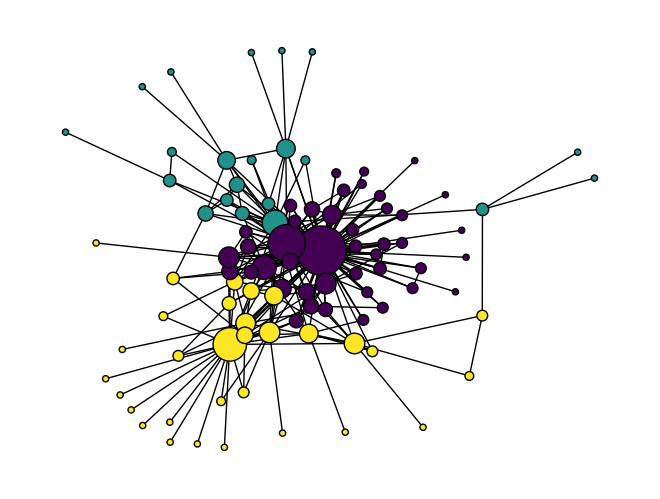

In [11]:
color = kmeans.labels_
size = [n*20 for n in dict(nx.degree(G)).values()]
nx.draw(G, node_color=color, node_size=size, edgecolors='#000')

Node2Vec has succeeded in identifying nodes that are near one another as similar. It could be interesting to compare this method to the community detection algorithms we learned in the last section. 

Though community detection is a common use of node2vec, once you've generated the vectors you can use them for a wide range of supervised and unsupervised machine learning tasks.